## Семинар 9: "LSTM"

ФИО: Притугин Михаил Алексеевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        h, c = hidden
        bs = h.size(0)
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

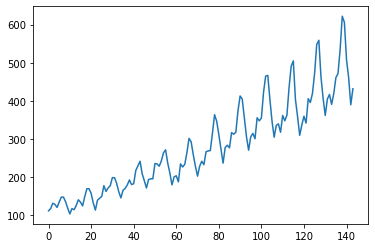

In [29]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [30]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [31]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [32]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [33]:
# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [34]:
look_back = 40
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [35]:
class PassengerDataset(Dataset):
    def __init__(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY

    def __len__(self):
        return len(self.trainY)

    def __getitem__(self, idx):
        return self.trainX[idx], self.trainY[idx]
    
train_dataset = PassengerDataset(trainX, trainY)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)

test_dataset = PassengerDataset(testX, testY)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Torch Realization

In [13]:
class TorchLSTM(nn.Module):
    def __init__(self, hidden_dim, num_layers=1):
        super(TorchLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)

        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(1)
        batch_size = inp.size(0)
        hidden = (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)).cpu(),
                  Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)).cpu())
        inp = pack_sequence(inp)
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out, _ = pad_packed_sequence(lstm_out, False)
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [14]:
def generate(model, n, inputs, batch_first=True):
    result = np.zeros(n + len(inputs))
    result[:len(inputs)] = inputs
    inp = 0
    for i in range(n):
        if batch_first:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(1, len(inputs), 1).cpu()
        else:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(len(inputs), 1, 1).cpu()
        res = lstm(inp)
        result[i + len(inputs)] = res[-1].cpu().data.numpy()
    return result

In [15]:
lstm = TorchLSTM(8, 1).cpu()

In [16]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, 1)

In [17]:
from time import time
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence

In [18]:
n_epochs = 1000
loss_f = nn.MSELoss()
start = time()
for reduce in range(3):
    for epoch in range(n_epochs):
        losses = []
        for X, Y in train_dataloader:
            lstm.zero_grad()
            X = Variable(torch.FloatTensor(X)).view(-1, look_back, 1).cpu()
            Y = Variable(torch.FloatTensor(Y)).view(-1, 1).cpu()
            p = lstm(X)
            
            loss = loss_f(p, Y)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            elapsed = time() - start
            print('Эпоха: {}\tОшибка: {:.3e}\tВремя: {:.2f}s'.format(epoch, np.mean(losses), elapsed))
            start = time()
    scheduler.step()

Эпоха: 0	Ошибка: 2.851e-01	Время: 0.04s
Эпоха: 100	Ошибка: 3.573e-03	Время: 1.11s
Эпоха: 200	Ошибка: 2.320e-03	Время: 1.08s
Эпоха: 300	Ошибка: 1.677e-03	Время: 1.32s
Эпоха: 400	Ошибка: 1.295e-03	Время: 1.37s
Эпоха: 500	Ошибка: 9.447e-04	Время: 1.39s
Эпоха: 600	Ошибка: 1.685e-03	Время: 1.48s
Эпоха: 700	Ошибка: 7.482e-04	Время: 1.17s
Эпоха: 800	Ошибка: 8.159e-04	Время: 1.43s
Эпоха: 900	Ошибка: 6.323e-04	Время: 1.36s
Эпоха: 0	Ошибка: 6.689e-04	Время: 1.40s
Эпоха: 100	Ошибка: 5.552e-04	Время: 1.32s
Эпоха: 200	Ошибка: 5.384e-04	Время: 1.31s
Эпоха: 300	Ошибка: 3.865e-04	Время: 1.30s
Эпоха: 400	Ошибка: 5.479e-04	Время: 1.31s
Эпоха: 500	Ошибка: 5.516e-04	Время: 1.31s
Эпоха: 600	Ошибка: 3.469e-04	Время: 1.48s
Эпоха: 700	Ошибка: 3.644e-04	Время: 1.20s
Эпоха: 800	Ошибка: 4.401e-04	Время: 1.61s
Эпоха: 900	Ошибка: 3.148e-04	Время: 1.45s
Эпоха: 0	Ошибка: 3.302e-04	Время: 1.78s
Эпоха: 100	Ошибка: 3.418e-04	Время: 1.40s
Эпоха: 200	Ошибка: 2.759e-04	Время: 1.29s
Эпоха: 300	Ошибка: 2.549e-04	Время: 1.32

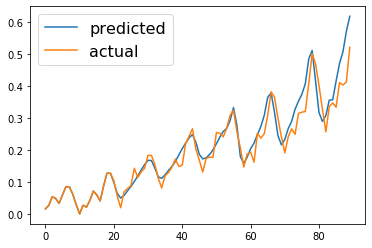

In [19]:
seq = train[:,0]
start = 0
plength = 70
blength = 20
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)

# My realization

In [36]:
class MyLSTM(nn.Module):
    def __init__(self, hidden_dim):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = LSTM(1, hidden_dim)
        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(0)
        batch_size = inp.size(1)
        hidden = (Variable(torch.zeros(batch_size, self.hidden_dim)).cpu(),
                  Variable(torch.zeros(batch_size, self.hidden_dim)).cpu())
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [37]:
lstm = MyLSTM(8).cpu()

In [38]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-1)
scheduler = StepLR(optimizer, 1)

In [39]:
n_epochs = 1000
loss_f = nn.MSELoss()
start = time()
for reduce in range(3):
    for epoch in range(n_epochs):
        losses = []
        for X, Y in train_dataloader:
            lstm.zero_grad()
            X = Variable(X.permute(1,0).unsqueeze(-1)).cpu()
            Y = Variable(Y).cpu()
            p = lstm(X).squeeze()
            
            loss = loss_f(p, Y)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            elapsed = time() - start
            print('Эпоха: {}\tОшибка: {:.3e}\tВремя: {:.2f}s'.format(epoch, np.mean(losses), elapsed))
            start = time()
    scheduler.step()

Эпоха: 0	Ошибка: 5.885e-02	Время: 0.03s
Эпоха: 100	Ошибка: 2.054e-03	Время: 1.69s
Эпоха: 200	Ошибка: 1.992e-03	Время: 1.68s
Эпоха: 300	Ошибка: 1.959e-03	Время: 1.74s
Эпоха: 400	Ошибка: 1.930e-03	Время: 1.69s
Эпоха: 500	Ошибка: 1.888e-03	Время: 1.73s
Эпоха: 600	Ошибка: 1.815e-03	Время: 1.75s
Эпоха: 700	Ошибка: 6.644e-03	Время: 1.75s
Эпоха: 800	Ошибка: 1.712e-03	Время: 1.62s
Эпоха: 900	Ошибка: 1.249e-03	Время: 1.59s
Эпоха: 0	Ошибка: 1.510e-03	Время: 1.60s
Эпоха: 100	Ошибка: 1.452e-03	Время: 1.60s
Эпоха: 200	Ошибка: 1.380e-03	Время: 1.59s
Эпоха: 300	Ошибка: 1.237e-03	Время: 1.60s
Эпоха: 400	Ошибка: 1.027e-03	Время: 1.60s
Эпоха: 500	Ошибка: 8.448e-04	Время: 1.60s
Эпоха: 600	Ошибка: 7.197e-04	Время: 1.60s
Эпоха: 700	Ошибка: 5.674e-04	Время: 1.60s
Эпоха: 800	Ошибка: 4.817e-04	Время: 1.60s
Эпоха: 900	Ошибка: 4.139e-04	Время: 1.60s
Эпоха: 0	Ошибка: 3.319e-04	Время: 1.64s
Эпоха: 100	Ошибка: 3.228e-04	Время: 1.64s
Эпоха: 200	Ошибка: 3.135e-04	Время: 1.85s
Эпоха: 300	Ошибка: 3.039e-04	Время: 1.70

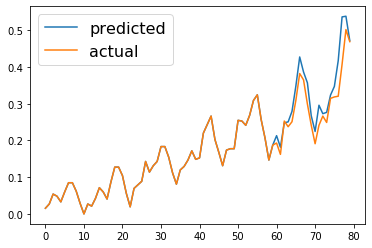

In [47]:
seq = train.reshape(-1)
start = 0
plength = 20
blength = 60
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base, batch_first=0)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: